### Importing Data 


In [62]:
# General imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Regression imports 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder


In [63]:
# Importing Data 
train_data = pd.read_csv("files/train.csv") # Training data
test_data = pd.read_csv("files/test.csv") # Prediction data

### EDA

Here I am getting the basic structure of the data, which will guide future exploration 

In [64]:
# First few rows 
print(train_data.head().to_string())

# Basic Structutre
print(train_data.shape) # 81 columns and 1460 rows
print(train_data.info()) # We have int, float, and object columns

# Get the count of each dtype in the DataFrame
dtype_counts = train_data.dtypes.value_counts()
print(dtype_counts) # We have 43 categorical, 35 int, and 3 float

# --------------------------------- Observation -------------------------------- #
# 1.  Alley, FireplaceQu, MasVnrType, PoolQC, Fence, and MiscFeature have a lot of missing values 

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside   

Here, I am checking the count of missing values and using domain knowledge to determine, how to potentially deal with them. 

In [65]:
# Missing values 
missing_values = train_data.isna().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values.sort_values(ascending=False))

# --------------------------------- Observation -------------------------------- #
# 1. PoolQC, MiscFeature, Alley, and Fence, have the most missing values with over 1000 values missing 
# 2. Certain columns may have null values because those items are not available
    # * Alley - House does not have an alley 
    # * PoolQC - House may not have a pool, so there will be no quality to the pool
    # * Fence - House may not have a fence
    # * MiscFeature - House may not have a feature
    # * FireplaceQu - House may not have a fireplace, so there will be no quality to the fireplace
    # * The garage columns all have the same amount of missing values, so it is possible that the house does not have a garage
    # * The basement columns all have around the same amount of missing values, so it is possible that the house does not have a basement
    # * I am not sure about lot frontage



PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


Here, I am checking the distribution of each numeric column, to determine if any tranformation/ scaling would be needed for any

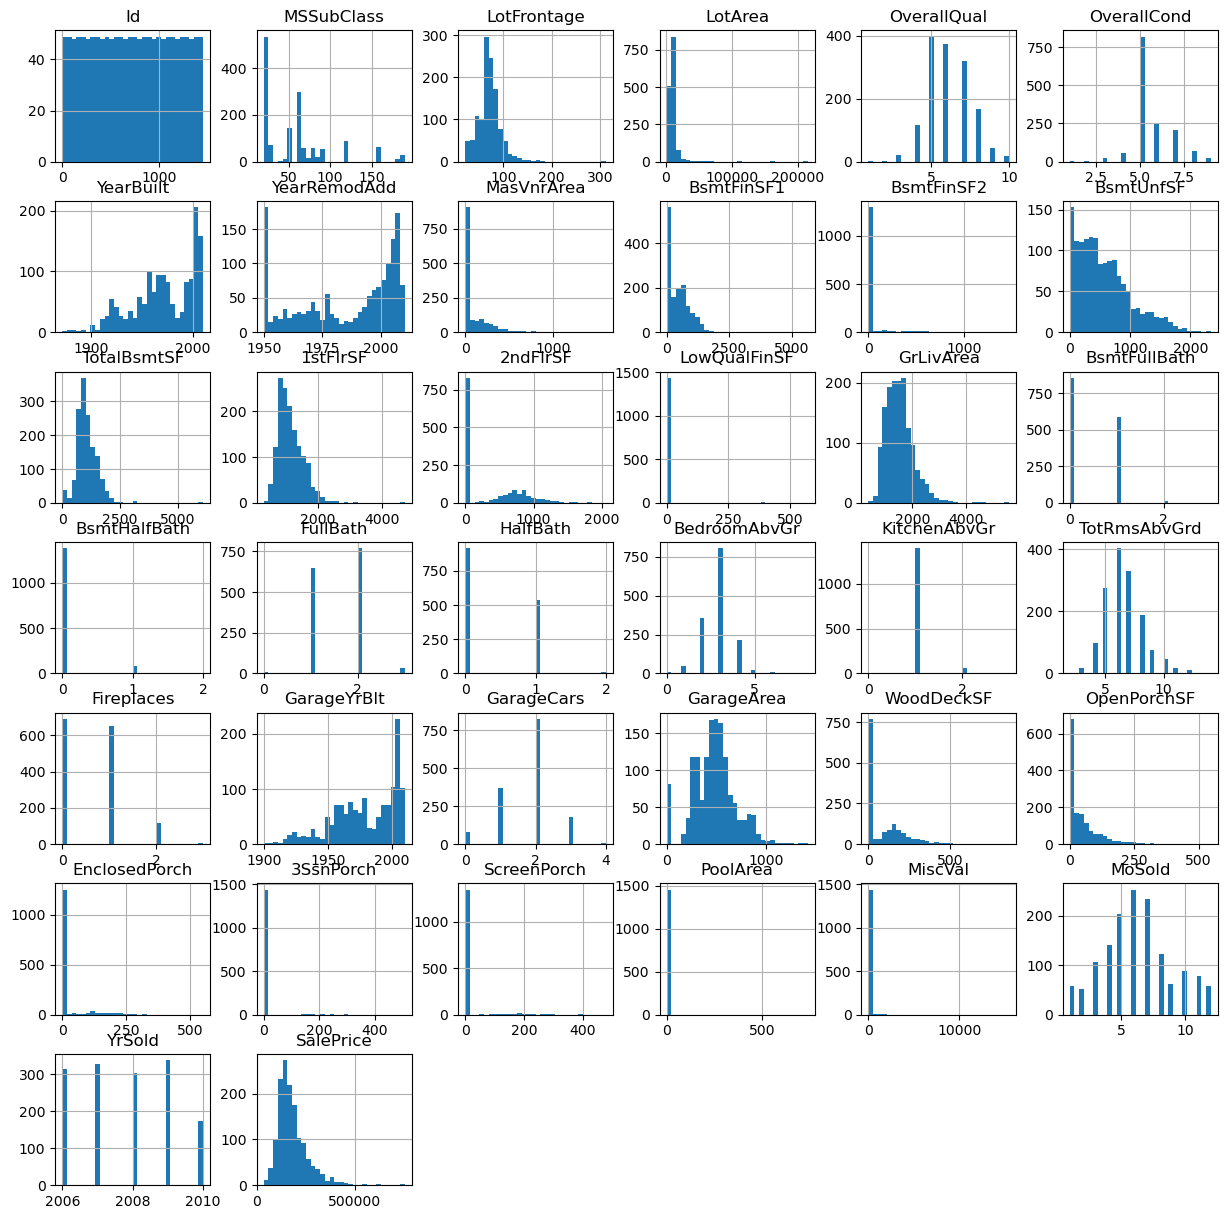

In [66]:
# Select numerical features
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms
train_data[numerical_cols].hist(figsize=(15, 15), bins=30)
plt.show()

# --------------------------------- Observation -------------------------------- #
# 1. Most fetures do not look like they have a normal distribution 
# 2. Sales price, BSMTUnfSf, TotalBsmtSF, 1stfltsf, GrlivArea, have a right skew 
# 3. Yearbuilt, GarageYrBlt, have a left skew 
# 4. Low QualFinSf, lot area, screen porch, open porch, wood deck, and some more have extreme outliers, 

Here, I am checking on the correlation of the numeric column visually. This helps me determine which features are more important for thr future model. It also helps me determine which feaure may be redundent - have high corr with each other 

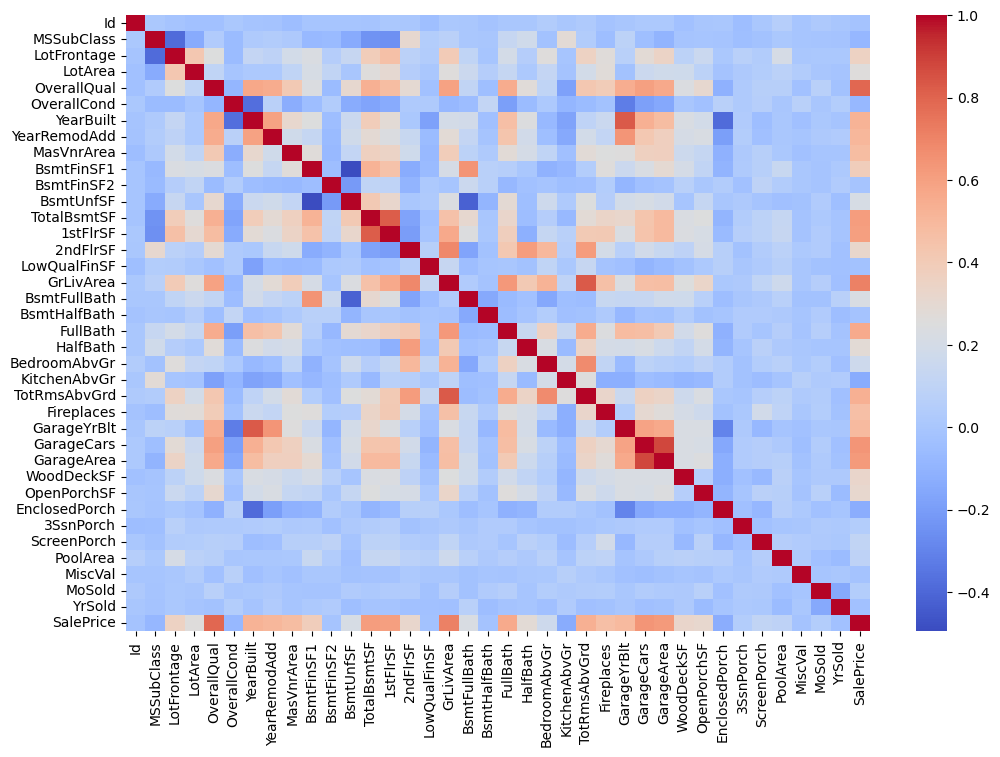

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [67]:
# Select only numerical columns
numerical_cols = train_data.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numerical_cols.corr()

# Visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

# --------------------------------- Observation -------------------------------- #
# 1. OveralQual, GRLivearea, The garage columns, 1stflrsf, year built, among a couple more have the hoghest correlation. Visaully more than 50%
# 2. Year built and garage year built are highly correlated
# 3. Grlivearea and totrmsabvgrd are also highly correlated
# 4. Total basment sf and first floor sf are also highly correlated
# 5. Bedrooms above ground and total rooms above ground are also highly correlated
# There are more but these are the once that stand out 


# Find features with high correlation to SalePrice (> 0.8)
high_corr_with_saleprice = corr_matrix["SalePrice"].abs().sort_values(ascending=False)
high_corr_with_saleprice = high_corr_with_saleprice[high_corr_with_saleprice > 0.5]
print(high_corr_with_saleprice)


In [68]:
# Find pairs of features that have very high correlation (> 0.8)
high_corr_features = corr_matrix.abs().unstack().sort_values(ascending=False)

# Remove self-correlations (correlation of a feature with itself is always 1)
high_corr_features = high_corr_features[high_corr_features < 1]

# Display only pairs with correlation > 0.8
print(high_corr_features[high_corr_features > 0.8])

# --------------------------------- Observation -------------------------------- #
# 1. TotalBsmtSF and 1stFlrSF have a high correlation of .81
# 2. GarageArea and GarageCars have a high correlation of .88
# 3. YearBuilt and GarageYrBlt have a high correlation of .82
# 4. TotRmsAbvGrd and GrLivArea have a high correlation of .82

GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
GarageYrBlt   YearBuilt       0.825667
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
dtype: float64


Here, I am checking for outliers using a box plot 

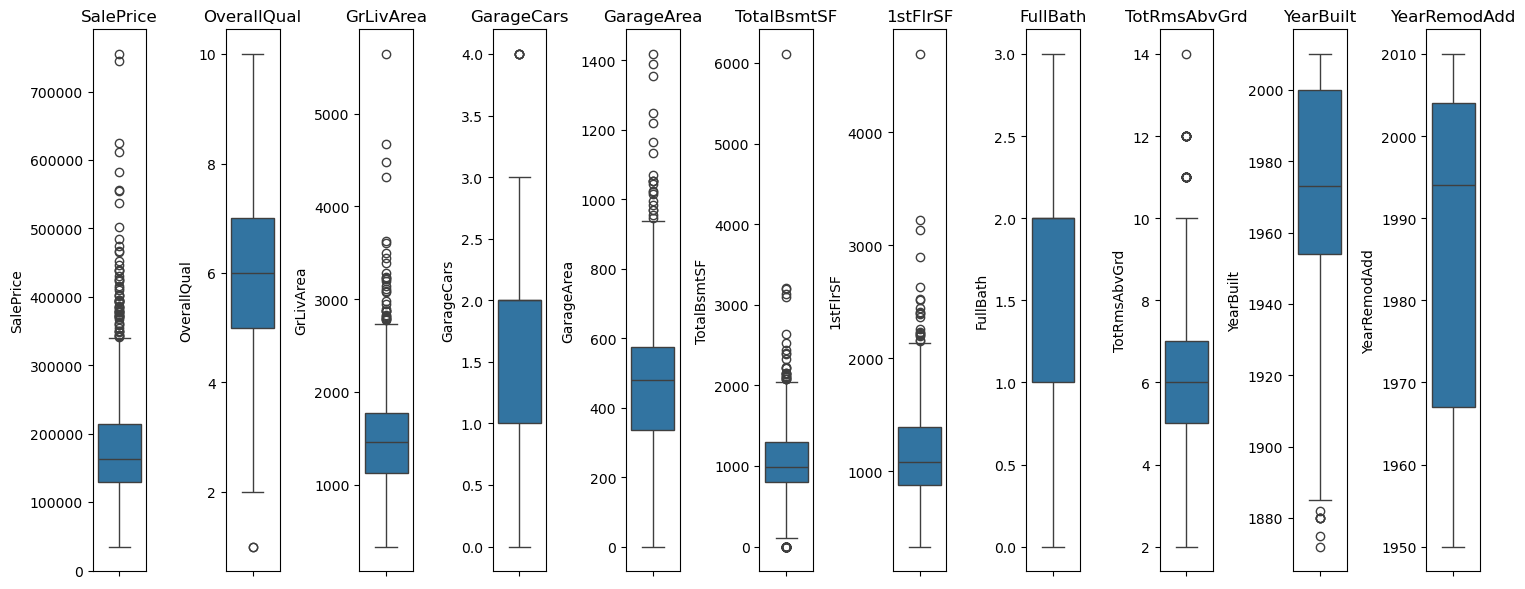

In [69]:
# Get feature names
key_features = high_corr_with_saleprice.index.tolist()

# Plot boxplots for key features
plt.figure(figsize=(15, 6))
for i, feature in enumerate(key_features, 1):
    plt.subplot(1, len(key_features), i)
    sns.boxplot(y=train_data[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

# --------------------------------- Observation -------------------------------- #
# 1. Sales price has a high number of outliers - but this is to be expected because mouse houses are around the same range of prices
# 2. TotalBsmtSF and 1stFlrSF have a high number of outliers
# 3. GarageArea, GrLivArea, 1stFlrSF and TotRmsAbvGrd have a high number of outliers

### Handling NA values 

In [70]:
# Count missing values per column (sorted)
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print(missing_values)
print()

# Checking correaltion of missing values, with SalePrice
numerical_missing = train_data[missing_values.index].select_dtypes(include=['int64', 'float64']).columns
missing_corr_with_saleprice = corr_matrix["SalePrice"][numerical_missing].sort_values(ascending=False)

print(missing_corr_with_saleprice)

# --------------------------------- Observation -------------------------------- #
# 1. GarageYrBlt and MasVnrArea have above a .45 corelation with SalePrice
    # .Missing values for GarageyYrBlt indiciate that there is not a garage

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

GarageYrBlt    0.486362
MasVnrArea     0.477493
LotFrontage    0.351799
Name: SalePrice, dtype: float64


Here I combine the test data and the prediction data - so any changes done to train will be done to prediction. I will split them up once I finish with the changes

In [71]:
# Combining Train and test data
all_data = pd.concat([train_data.drop('SalePrice', axis = 1), test_data], ignore_index = True)

print(f"Combined train and test data! Shape:", {all_data.shape})


Combined train and test data! Shape: {(2919, 80)}


Combining the data introduced more missing values, and newer columns with missing values. But because of my earlier EDA, i have a sence of what to do to these columns  

In [72]:
# Missing Values 
missing_values = all_data.isna().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending= False)

print(missing_values)

cat_missing = all_data[missing_values.index].select_dtypes(include=['object']).columns
print(cat_missing)


PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64
Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MSZoning', 'Functional', 'Utilities', 'Ele

The na values in the categorical columns represent no data, therefore i decided to encode them as none. For example If a house does not have a fence, it makes no sence for it to have a fence_area property, or fense_quality property. Therfore columns like that will have none 

In [73]:
# Replace NA values in Cat columns with none

for feature in cat_missing:
    all_data[feature] = all_data[feature].fillna("None") 

In [74]:
num_missing_values = all_data.isna().sum()
num_missing_values = num_missing_values[num_missing_values > 0].sort_values(ascending= False)

print(num_missing_values)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
GarageArea        1
dtype: int64


Ideally, I should have utalized a more effecient method to find the missing numeric values, but i went with filling the na values with 0. I did this mainly for the simplicity and the fact that 2 columns dominate the numeric missing values, yet not do not add much to the overall model - they do not have a high correlation to the sale price. As a result I did not see the reason to spent more time on them - thus they ar replace with 0

In [75]:
# Missing num values 
replaceFeatures = ["LotFrontage", "GarageYrBlt", "GarageCars", "GarageArea", "BsmtFullBath", "BsmtHalfBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]

for numFeature in replaceFeatures:
    all_data[numFeature] = all_data[numFeature].fillna(0)

In [76]:
# Checking if there is anymore missing values 
num_missing_values = all_data.isna().sum()
num_missing_values = num_missing_values[num_missing_values > 0].sort_values(ascending= False)

print(num_missing_values)

Series([], dtype: int64)


### Feature Engerniring 

In [77]:
# Getting all the cat columns with their unique values
catColumns = all_data.select_dtypes(include=['object']).columns

#print(catColumns)

for feature in catColumns:
    categories = all_data[feature].unique()
    print(feature, categories)


MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH' 'None']
Street ['Pave' 'Grvl']
Alley ['None' 'Grvl' 'Pave']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa' 'None']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st ['V

Here I have chosen the cat columns that seem to have an ordering, in order to label encode them.

In [78]:
# Label encoding 
ordinal_features = {

    "ExterQual": ["Fa", "TA", "Gd", "Ex"],
    "ExterCond" : ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["None", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["None", "Po", "Fa", "TA", "Gd"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtExposure": ["None", "No", "Mn", "Av", "Gd"],  
    "BsmtFinType1": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],  
    "BsmtFinType2": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["None", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"], 
    "GarageFinish": ["None", "Unf", "RFn", "Fin"],  
    "GarageQual": ["None", "Po", "Fa", "TA", "Gd", "Ex"],  
    "GarageCond": ["None", "Po", "Fa", "TA", "Gd", "Ex"],  
    "FireplaceQu": ["None", "Po", "Fa", "TA", "Gd", "Ex"],  
    "KitchenQual": ["None", "Po", "Fa", "TA", "Gd", "Ex"],  
    "PoolQC": ["None", "Fa", "TA", "Gd", "Ex"],  
    "Fence": ["None", "MnWw", "GdWo", "MnPrv", "GdPrv"],  
}

# Apply label encoding
for feature, categories in ordinal_features.items():
    le = LabelEncoder()
    le.fit(categories)
    all_data[feature] = le.transform(all_data[feature])

print("Label encoding applied to ordinal features.")



Label encoding applied to ordinal features.


Similar to what I did earler, I have chosen the rest of the cat columns, those with no ordering and I am one hot encoding them

In [79]:
# Nominal Categories 
nominal_features = [
    "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities",
    "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2",
    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st",
    "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir",
    "Electrical", "SaleType", "SaleCondition", "GarageType", "PavedDrive",
    "MiscFeature"
]

# One-hot encode nominal categorical features
all_data = pd.get_dummies(all_data, columns=nominal_features, drop_first=True)

print("Applied One-Hot Encoding to nominal features.")


Applied One-Hot Encoding to nominal features.


Here I am getting an idea of which numeric columns may be continous

In [80]:
numerical_features = all_data.select_dtypes(include=["int64", "float64"]).columns
#print(numerical_features)

for feature in numerical_features:
    print(feature, all_data[feature].describe().to_list())


Id [2919.0, 1460.0, 842.7870430897713, 1.0, 730.5, 1460.0, 2189.5, 2919.0]
MSSubClass [2919.0, 57.1377183967112, 42.51762782915043, 20.0, 20.0, 50.0, 70.0, 190.0]
LotFrontage [2919.0, 57.76670092497431, 33.48163554686434, 0.0, 43.0, 63.0, 78.0, 313.0]
LotArea [2919.0, 10168.11408016444, 7886.996359105552, 1300.0, 7478.0, 9453.0, 11570.0, 215245.0]
OverallQual [2919.0, 6.089071599862967, 1.409947206614689, 1.0, 5.0, 6.0, 7.0, 10.0]
OverallCond [2919.0, 5.564576909900651, 1.113130746637732, 1.0, 5.0, 5.0, 6.0, 9.0]
YearBuilt [2919.0, 1971.3127783487496, 30.29144153412115, 1872.0, 1953.5, 1973.0, 2001.0, 2010.0]
YearRemodAdd [2919.0, 1984.2644741349777, 20.89434423384067, 1950.0, 1965.0, 1993.0, 2004.0, 2010.0]
MasVnrArea [2919.0, 101.3960260363138, 178.85457867551298, 0.0, 0.0, 0.0, 163.5, 1600.0]
ExterQual [2919.0, 2.5306611853374443, 0.7022449617205759, 0.0, 2.0, 3.0, 3.0, 3.0]
ExterCond [2919.0, 3.708804385063378, 0.7736412678213106, 0.0, 4.0, 4.0, 4.0, 4.0]
BsmtQual [2919.0, 2.699897

Scaling the continuous numeric features 

In [81]:
# Selecting only continuous numerical columns (excluding categorical-like numbers)
continuous_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea",
    "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"
]

# Apply StandardScaler only to continuous features
scaler = StandardScaler()
all_data[continuous_features] = scaler.fit_transform(all_data[continuous_features])

print("Scaled only continuous numerical features.")


Scaled only continuous numerical features.


### Training 

Here I undo the concatination of the training and prediction data 

In [82]:
# Undoing the split for train and prediction data
train_rows = train_data.shape[0]  # Get original training data size
X = all_data.iloc[:train_rows, :]  # Features for training
y = train_data["SalePrice"]  # Target variable
predict_X = all_data.iloc[train_rows:, :]  # Features for final predictions

# Droping id in X
X = X.drop("Id", axis=1)


print("Train set shape:", X.shape)
print("Test set shape:", predict_X.shape)



Train set shape: (1460, 212)
Test set shape: (1459, 213)


Here, I split the train data into train and test 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_test.shape)

Training set shape: (1168, 212)
Validation set shape: (292, 212)


Simple Linear Regression 

In [86]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


# mse
mse = mean_squared_error(y_test, y_pred)

# rmse
rmse = np.sqrt(mse)

# r_score 
r2_test = lr.score(X_test, y_test)
r2 = lr.score(X_train, y_train)

print("R2 test Score:", r2_test)
print("R2 train Score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

R2 test Score: 0.6899534918399297
R2 train Score: 0.9225325245009655
Mean Squared Error: 2378157856.987045
Root Mean Squared Error: 48766.359890677144


#### Lasso

In [87]:
# Initialize Lasso Regression with alpha 200
lasso = Lasso(alpha=200, max_iter=10000) 
# Train the model on training data
lasso.fit(X_train, y_train)

# Predict on validation set
y__preds = lasso.predict(X_test)


# mse
mse = mean_squared_error(y_test, y__preds)

# rmse
rmse = np.sqrt(mse)

# r_score
r2_test = lasso.score(X_test, y_test)
r2 = lasso.score(X_train, y_train)

print("R2 test Score:", r2_test)
print("R2 train Score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)




R2 test Score: 0.8624773304075146
R2 train Score: 0.8725117368183047
Mean Squared Error: 1054843736.6575762
Root Mean Squared Error: 32478.35797354257


#### Ridge

In [88]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize Ridge Regression with alpha (higher alpha = more regularization)
ridge = Ridge(alpha=10, max_iter=10000)  # Adjust alpha as needed

# Train the model on training data
ridge.fit(X_train, y_train)

# Predict on validation set
y__preds = ridge.predict(X_test)

# mse
mse = mean_squared_error(y_test, y__preds)

# rmse
rmse = np.sqrt(mse)

# r_score
r2_test = ridge.score(X_test, y_test)
r2 = ridge.score(X_train, y_train)

print("R2 test Score:", r2_test)
print("R2 train Score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


R2 test Score: 0.8655069949326002
R2 train Score: 0.8834809729602624
Mean Squared Error: 1031605221.4518272
Root Mean Squared Error: 32118.61176096855


Ridge - GrissearchCV - Best parameters

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import numpy as np

# Define a range of alpha values to test
alpha_values = [0.1, 1, 5, 10, 20, 50, 100, 200, 500]

# Set up Ridge model with GridSearchCV
ridge = Ridge(max_iter=10000)
ridge_cv = GridSearchCV(ridge, param_grid={"alpha": alpha_values}, scoring="neg_mean_squared_error", cv=5)

# Train on the full training set
ridge_cv.fit(X_train, y_train)

# Get the best alpha
best_alpha = ridge_cv.best_params_["alpha"]
print(f"Best Alpha: {best_alpha}")

# Train Ridge with the best alpha
ridge_best = Ridge(alpha=best_alpha, max_iter=10000)
ridge_best.fit(X_train, y_train)

# Predict on validation set
y__preds = ridge_best.predict(X_test)

# mse
mse = mean_squared_error(y_test, y__preds)

# rmse
rmse = np.sqrt(mse)

# r_score
r2_test = ridge_best.score(X_test, y_test)
r2 = ridge_best.score(X_train, y_train)

print("\nFinal Ridge Regression Performance (Optimized Alpha):")
print(f"Best Alpha: {best_alpha}")
print(f"R² (Train): {r2:.4f}")
print(f"R² (Test): {r2_test:.4f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Best Alpha: 10

Final Ridge Regression Performance (Optimized Alpha):
Best Alpha: 10
R² (Train): 0.8835
R² (Test): 0.8655
Mean Squared Error: 1031605221.45
Root Mean Squared Error: 32118.61


#### Predictions 

In [96]:
def make_predictions(model, predictor):
    """
    Takes a trained model and test data to generate predictions.
    
    Args:
    - model: Trained machine learning model (Ridge, Lasso, etc.).
    - predictor: DataFrame containing test set features, including 'Id'.

    Returns:
    - A DataFrame with 'Id' and 'SalePrice'.
    """
    # Extract 'Id' column
    test_ids = predictor["Id"]

    # Extract only features (excluding 'Id')
    X_test = predictor.drop(columns=["Id"])

    # Make predictions
    predictions = model.predict(X_test)

    # Ensure predictions are positive (house prices can't be negative)
    predictions = [max(0, price) for price in predictions]

    # Create DataFrame
    output = pd.DataFrame({"Id": test_ids, "SalePrice": predictions})

    # Making Id index 
    output.set_index("Id", inplace=True)

    return output


Output for the Lasso Regression 

In [100]:
lasso_output = make_predictions(lasso, predict_X)
print(lasso_output)

# Make into csv file
lasso_output.to_csv("lasso_output.csv")


          SalePrice
Id                 
1461  103262.338960
1462  147039.241611
1463  166157.077516
1464  177847.796417
1465  225727.951943
...             ...
2915   69857.376046
2916   66605.878746
2917  168247.544450
2918  117470.263377
2919  232939.356416

[1459 rows x 1 columns]


Output for both the Lasso and Ridge Regression 

In [97]:
lasso_output = make_predictions(lasso, predict_X)
ridge_output = make_predictions(ridge_best, predict_X)

output = pd.concat([lasso_output, ridge_output], axis=1)

In [98]:
print(output)

          SalePrice      SalePrice
Id                                
1461  103262.338960  101506.004983
1462  147039.241611  145336.549077
1463  166157.077516  163956.378887
1464  177847.796417  170850.999368
1465  225727.951943  218883.279690
...             ...            ...
2915   69857.376046   71023.480120
2916   66605.878746   62096.040360
2917  168247.544450  164526.768108
2918  117470.263377  102476.020389
2919  232939.356416  235381.213991

[1459 rows x 2 columns]
